In [3]:
from pylab import *
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2
import warnings
import os
from random import randint
import itertools

warnings.simplefilter("ignore")

In [4]:
def readNames(path):
    fileList = os.listdir(path)
    return fileList

def readFile(path,filename,tif = False):
    
    if not(tif):
        base = cv2.imread(os.getcwd() + '/' + path + filename)
        base = cv2.cvtColor(base, cv2.COLOR_RGB2BGR)
    else:
        base = plt.imread(os.getcwd() + '/' + path + filename)
    return base
    

In [42]:
def divide(image, size = 5):
    dividedImages = []
    
    halfSize = int(size/2)
    
    print(halfSize)
    
    
    for i in range (halfSize, len(image) - halfSize):
        for j in range (halfSize, len(image[i]) - halfSize):
            dividedImage = image[i - halfSize:i + halfSize + 1,j - halfSize:j + halfSize + 1]
            
            dividedImages.append([[i - halfSize, j - halfSize], dividedImage])
    return dividedImages


In [6]:
def showImg(base, image):
    fig = figure(figsize=(20,10))
    subplot(1,2,1)
    imshow(base,cmap='gray')
    subplot(1,2,2)
    imshow(image,cmap='gray')

In [7]:
def checkValue(data, i, j):
    return data[i,j] != 0

In [50]:
def cutFromImage(image, x_size, y_size, divided_image_size):
    y_center = int(len(image[0])/2)
    
    imageToCheck = image[int(divided_image_size/2) : x_size + int(divided_image_size/2), y_center - int(y_size/2) : y_center + int(y_size/2)]
    
    imageToDivide = image[0: x_size + divided_image_size, y_center - int(y_size/2) - int(divided_image_size/2) : y_center + int(y_size/2) + int(divided_image_size/2)]
    
    dividedImages = divide(imageToDivide, divided_image_size)
    
    return imageToCheck, dividedImages
    

In [62]:
def prepareSmallImage(num, size):
    pathImages = 'HRF/images/'
    imagesFileList = readNames(pathImages)
    imagesFileList.sort()
    
    image = readFile(pathImages,imagesFileList[num])
    smallImage, dividedSmallImages = cutFromImage(image, 400,400, size)
    return smallImage, dividedSmallImages

In [ ]:
def compare(num):
    image, dividedImages = prepareSmallImage(num, 100)
#     doRedStaff on image
#     doSieć staff on each of dividedImages to get value for each and get l

50


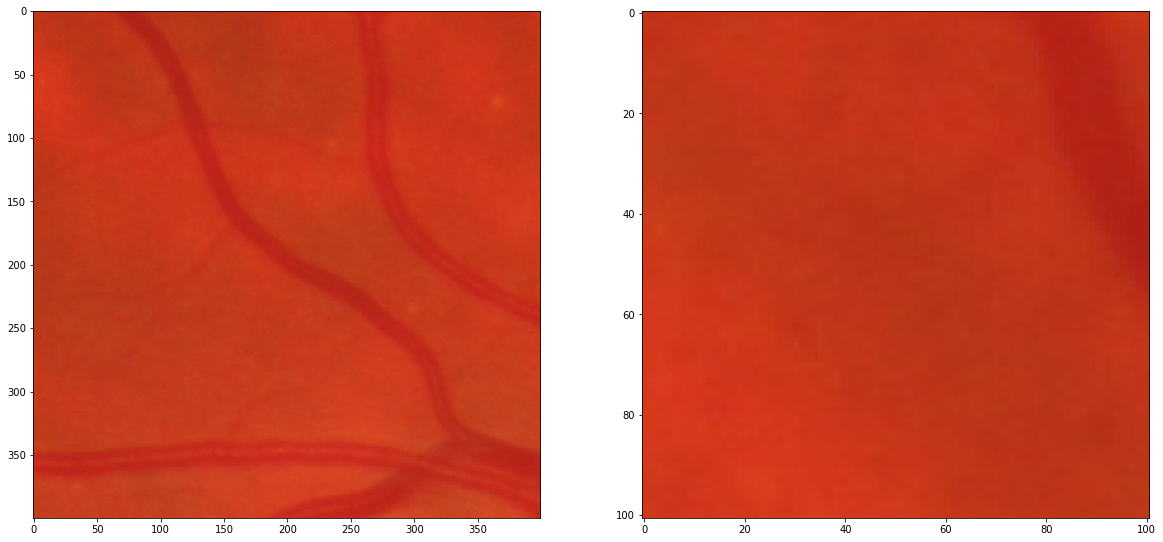

In [9]:

def meanError(image, dataFile):
    if image.shape != dataFile.shape:
        return 0
    
    error = 0.0
    for i in range(len(image)):
        for j in range(len(image[i])):
            error = error + (image[i,j]-dataFile[i,j])**2
            
    error = error / (dataFile.shape[0]*dataFile.shape[1])
    
    return error

def addVeinToImage(image, foundVeinImage):
    outputImage = image.copy()
    for i in range(len(image)):
        for j in range(len(image[i])):
            if foundVeinImage[i,j] == 255:
                outputImage[i,j] = [255,255,255]
                
    return outputImage

def takeRandomSmallImages(imageDataMask, size = 5, amount = 200):
    trueImages = []
    falseImages = []
    halfSize = int(size/2)
    while(len(trueImages) < amount or len(falseImages) < amount):
        x = randint(halfSize, len(imageDataMask[0])  - halfSize)
        y = randint(halfSize, len(imageDataMask[0][x])  - halfSize)
        #if (x-halfSize>=0 and x+halfSize+1<len(imageDataMask[0]) and y-halfSize>=0 and y+halfSize+1<len(imageDataMask[0][x])):
        if(np.all(imageDataMask[2][x, y] == 255)):
            #print('len x ', len(imageDataMask[0]))
            #print('len y ', len(imageDataMask[0][x]) -1)
            #print('x ',x, ' y ', y)
            if(imageDataMask[1][x, y] == 0):
                if(len(falseImages) < amount):
                    falseImages.append(imageDataMask[0][x - halfSize:x + halfSize,y - halfSize:y + halfSize])
            else:
                if(len(trueImages) < amount):
                    trueImages.append(imageDataMask[0][x - halfSize:x + halfSize,y - halfSize:y + halfSize])
    #print(trueImages[-1].shape, falseImages[0].shape)
    return trueImages, falseImages

[[200  55  26]
 [199  54  25]
 [199  56  26]
 ...
 [192  51  23]
 [191  52  23]
 [192  53  24]]


TypeError: Invalid dimensions for image data

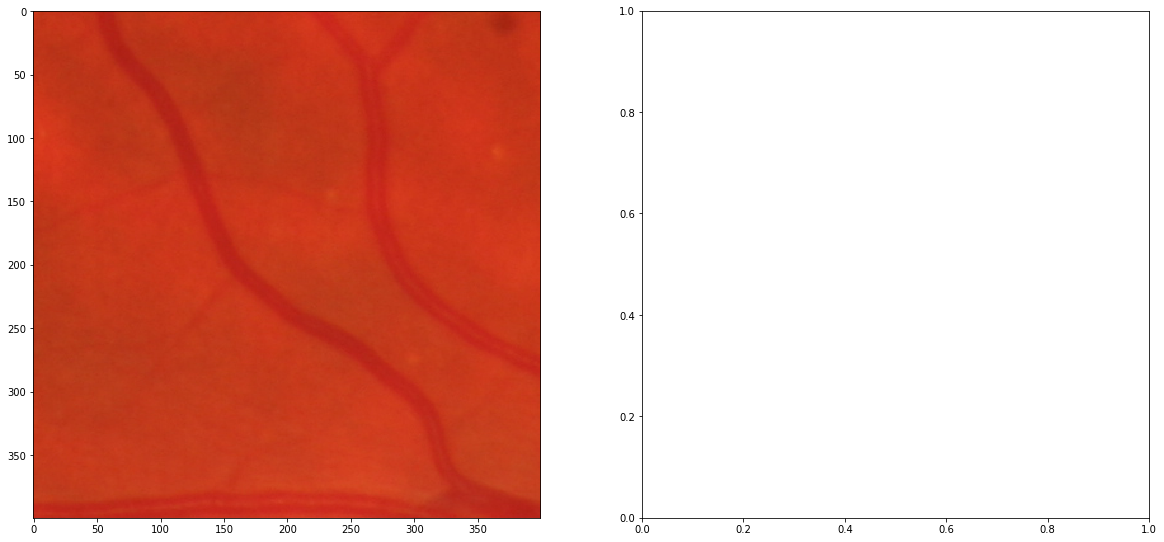

In [13]:
def prepareData(idList, size):
    pathImages = 'HRF/images/'
    pathData = 'HRF/manual1/'
    pathMask = 'HRF/mask/'
    imagesFileList = readNames(pathImages)
    dataFileList = readNames(pathData)
    maskFileList = readNames(pathMask)

    imagesFileList.sort()
    dataFileList.sort()
    maskFileList.sort()

    trueImagesList = []
    falseImagesList = []
    
    for imageId in idList:
        imageDataMask = getImageDataMask(imageId, [pathImages,pathData,pathMask], [imagesFileList,dataFileList,maskFileList])

        trueImages, falseImages = takeRandomSmallImages(imageDataMask, size)
        if(len(trueImagesList) == 0):
            trueImagesList = trueImages
            falseImagesList = falseImages
        else:
            trueImagesList = trueImagesList + trueImages
            falseImagesList = falseImagesList + falseImages
        
    return trueImagesList, falseImagesList

In [8]:
def prepareTrainData(imgNo, partSize):
    trueData, falseData = prepareData(imgNo, partSize)
    trueImgLen = len(trueData)
    falseImgLen = len(falseData)
    print('false ',falseImgLen)
    print('true ', trueImgLen)
    length = trueImgLen + falseImgLen
    print(length)

    #przypisanie etykiet 1-żyła, 0-inne
    labels = np.ones((length,), dtype=int)
    labels[0:trueImgLen] = 1
    labels[trueImgLen:] = 0
    print('len labels: ', len(labels))
    print(labels[trueImgLen-10:trueImgLen], labels[trueImgLen:trueImgLen+10])    
    
    images = trueData + falseData

    #konwersja do sklai szarości i ujednolicenie wymiarow
    showImg(images[0], images[falseImgLen+1])
    grayImages = toGrayScaleAndResize(images, partSize, partSize)
    print(grayImages[0].shape)
    showImg(grayImages[0], grayImages[-1])
        
    imgMatrix = np.array([np.array(img).flatten() for img in grayImages])

    #losowe rozmieszczenie obrazow w w zbiorze treningowym
    data, Label = shuffle(imgMatrix, labels, random_state=2)
    train_data = [data,Label]
    
    return train_data

In [15]:
def getImageDataMask(num, paths, fileLists):
    image = readFile(paths[0],fileLists[0][num])
    data = readFile(paths[1],fileLists[1][num], True)
    mask = readFile(paths[2], fileLists[2][num], True)
    
    return [image,data,mask]

In [16]:
def toGrayScaleAndResize(images, x, y, clahe=False):
    img = []
    for i in images:
        gray = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
        if clahe:
            cl = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            gray = cl.apply(gray)
        #img_rows, img_columns = 50, 50
        #img.append(cv2.resize(gray, (x, y)))
        img.append(gray)
        
    return img

false  1000
true  1000
2000
len labels:  2000
[1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0]
(30, 30)
2000 2000


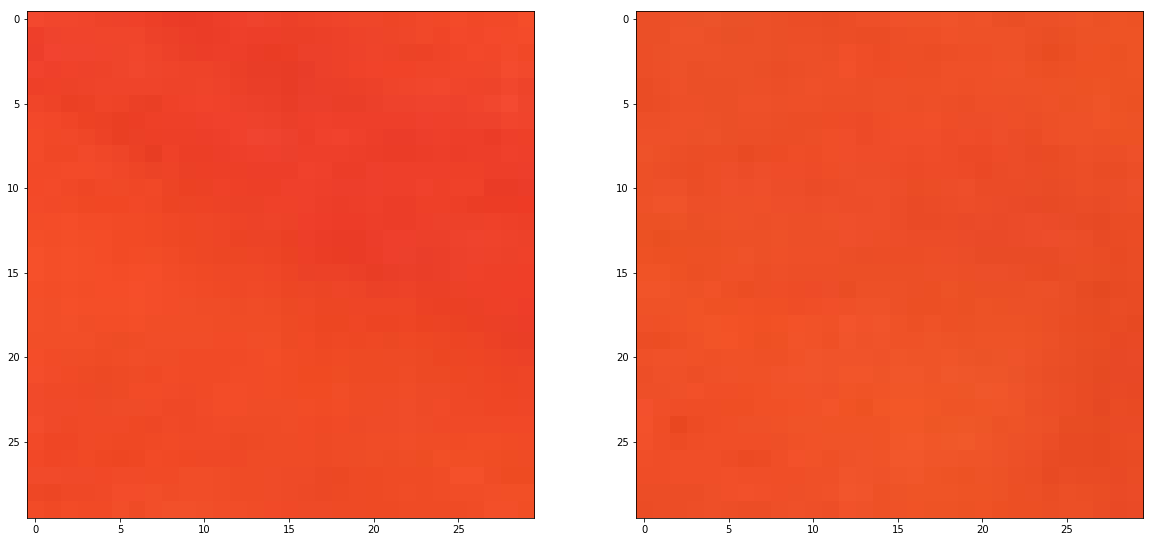

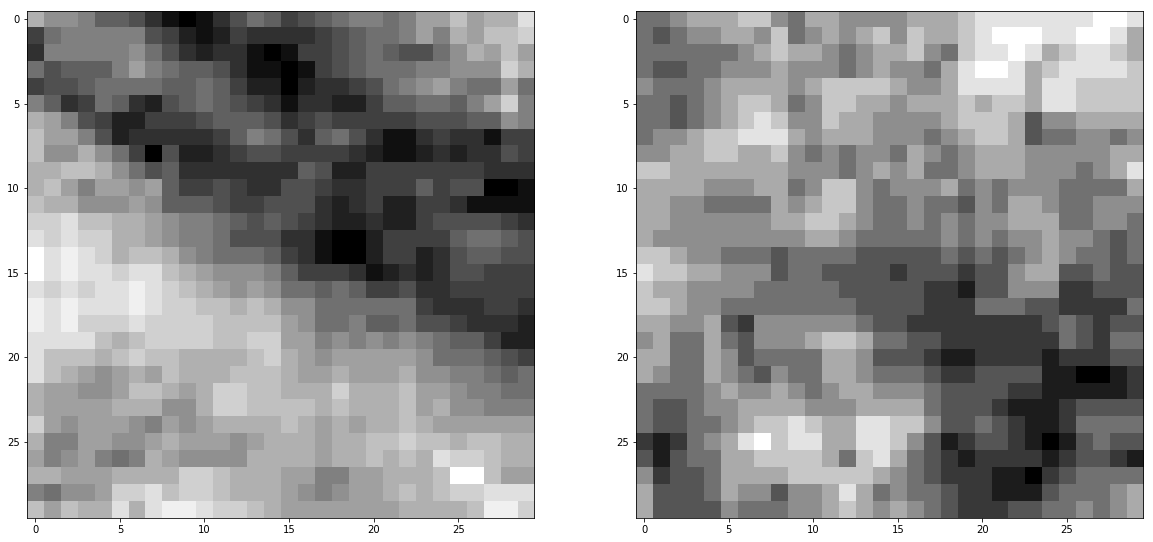

In [23]:
imgNo = range(5)
x = prepareTrainData(imgNo, 30)
print(len(x[0]), len(x[1]))

In [41]:
from __future__ import print_function
import numpy as np

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

In [31]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils


import theano
np.random.seed(7)

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [40]:
def buildCNN(train_data, size, epoch, fname='weights.hdf5'):
    (X, y) = (train_data[0],train_data[1])

    #zbiory treningowe i testowe

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    X_train = X_train.reshape(X_train.shape[0], size, size, 1)
    X_test = X_test.reshape(X_test.shape[0], size, size, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    #print('X_train shape:', X_train.shape)
    #print(X_train.shape[0], 'train samples')
    #print(X_test.shape[0], 'test samples')

    batch_size = 32
    nb_classes = 2
    nb_epoch = epoch
    nb_filters = 32
    nb_pool = 2
    nb_conv = 3
    
    

    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    
    print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

    #budowa modelu sieci neuronowej

    model = Sequential()

    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                            border_mode='valid',
                            input_shape=(size, size, 1)))
    convout1 = Activation('relu')
    model.add(convout1)
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    convout2 = Activation('relu')
    model.add(convout2)
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    #trenowanie modelu


    hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
                  verbose=1, validation_data=(X_test, Y_test))


    #hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
    #              verbose=1, validation_split=0.2)


    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    #print(model.predict_classes(X_test[1:3]))
    #print(Y_test[1:3])


    Y_pred = model.predict(X_test)
    #print(Y_pred)
    y_pred = np.argmax(Y_pred, axis=1)
    #print(y_pred)

    cm = confusion_matrix(np.argmax(Y_test,axis=1), y_pred)
    print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))

    # Plot normalized confusion matrix
    class_names = ['vein', 'other']

    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    
    model.save_weights(fname,overwrite=True)


false  6000
true  6000
12000
len labels:  12000
[1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0]
(30, 30)
(9600, 900) (2400, 900) (9600,) (2400,)
(9600, 30, 30, 1) (2400, 30, 30, 1) (9600, 2) (2400, 2)
Train on 9600 samples, validate on 2400 samples
Epoch 1/20
9600/9600 [==============================] - 32s 3ms/step - loss: 0.6940 - acc: 0.4938 - val_loss: 0.6931 - val_acc: 0.5008
Epoch 2/20
9600/9600 [==============================] - 32s 3ms/step - loss: 0.6934 - acc: 0.4981 - val_loss: 0.6932 - val_acc: 0.5012
Epoch 3/20
9600/9600 [==============================] - 33s 3ms/step - loss: 0.6935 - acc: 0.4978 - val_loss: 0.6931 - val_acc: 0.5012
Epoch 4/20
9600/9600 [==============================] - 33s 3ms/step - loss: 0.6934 - acc: 0.4948 - val_loss: 0.6932 - val_acc: 0.4983
Epoch 5/20
9600/9600 [==============================] - 34s 4ms/step - loss: 0.6931 - acc: 0.5034 - val_loss: 0.6932 - val_acc: 0.4983
Epoch 6/20
9600/9600 [==============================] - 37s 4ms/step - loss: 0.6

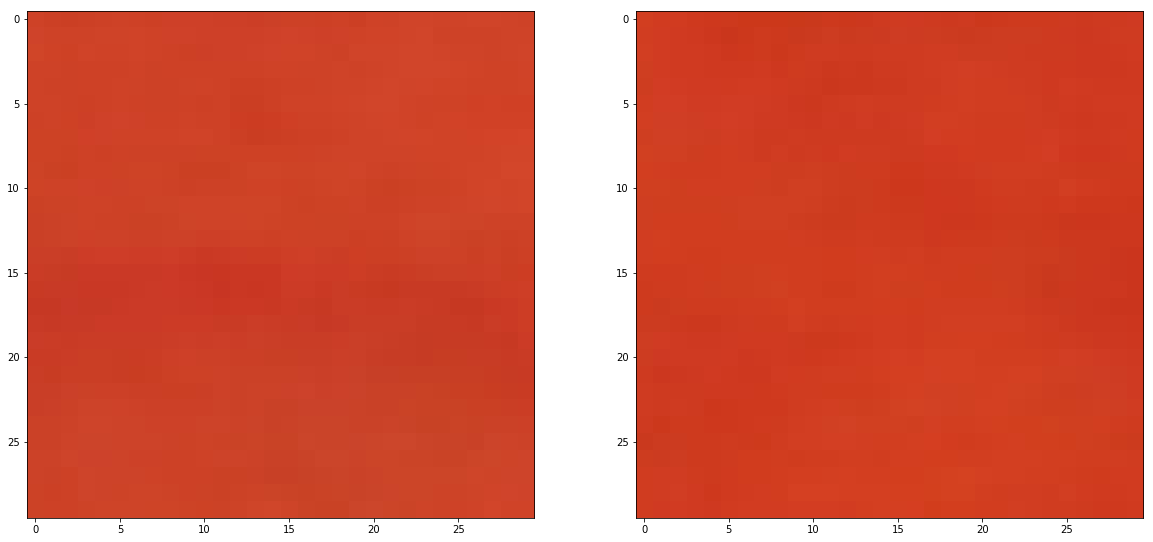

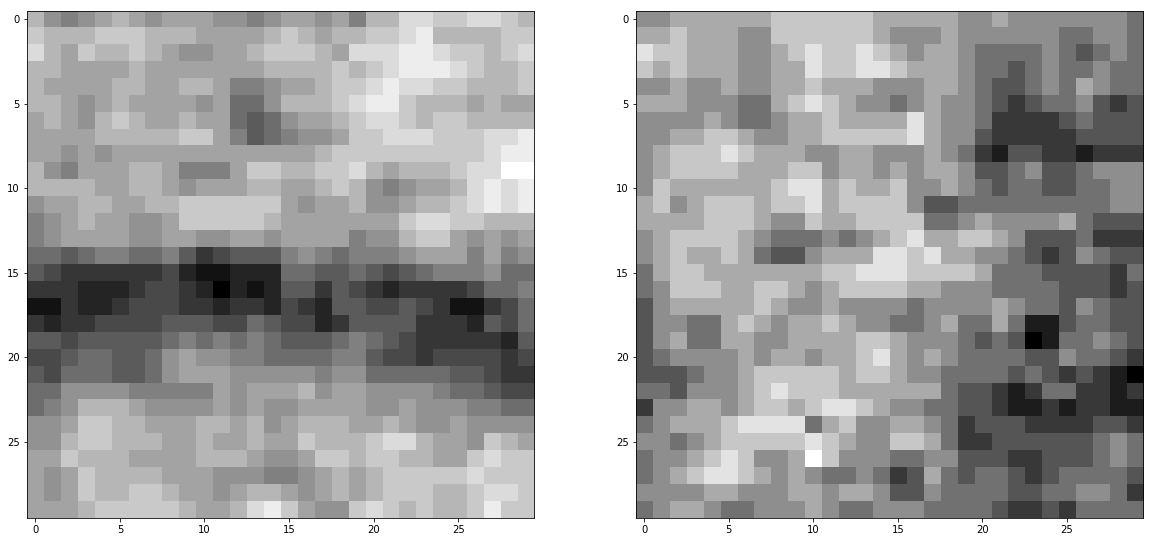

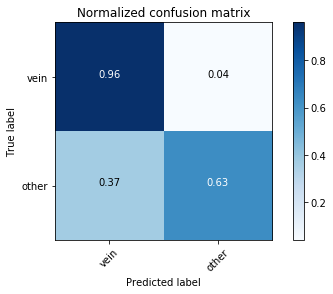

In [39]:
pictures = np.array(range(45))
imgNo = shuffle(pictures, random_state=0)
fname = '30_adadelta__crossentropy.hdf5'

partSize = 30
x = prepareTrainData(imgNo[:30], partSize)
buildCNN(x, partSize, 20, fname)


    

false  6000
true  6000
12000
len labels:  12000
[1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0]
(30, 30)
(9600, 900) (2400, 900) (9600,) (2400,)
(9600, 30, 30, 1) (2400, 30, 30, 1) (9600, 2) (2400, 2)
Train on 9600 samples, validate on 2400 samples
Epoch 1/20
9600/9600 [==============================] - 36s 4ms/step - loss: 0.6937 - acc: 0.4995 - val_loss: 0.6931 - val_acc: 0.4988
Epoch 2/20
9600/9600 [==============================] - 34s 4ms/step - loss: 0.6937 - acc: 0.4954 - val_loss: 0.6932 - val_acc: 0.4971
Epoch 3/20
9600/9600 [==============================] - 36s 4ms/step - loss: 0.6933 - acc: 0.4979 - val_loss: 0.6932 - val_acc: 0.5704
Epoch 4/20
9600/9600 [==============================] - 43s 4ms/step - loss: 0.6928 - acc: 0.5058 - val_loss: 0.6938 - val_acc: 0.4950
Epoch 5/20
9600/9600 [==============================] - 43s 4ms/step - loss: 0.6919 - acc: 0.5126 - val_loss: 0.6924 - val_acc: 0.5204
Epoch 6/20
9600/9600 [==============================] - 38s 4ms/step - loss: 0.6

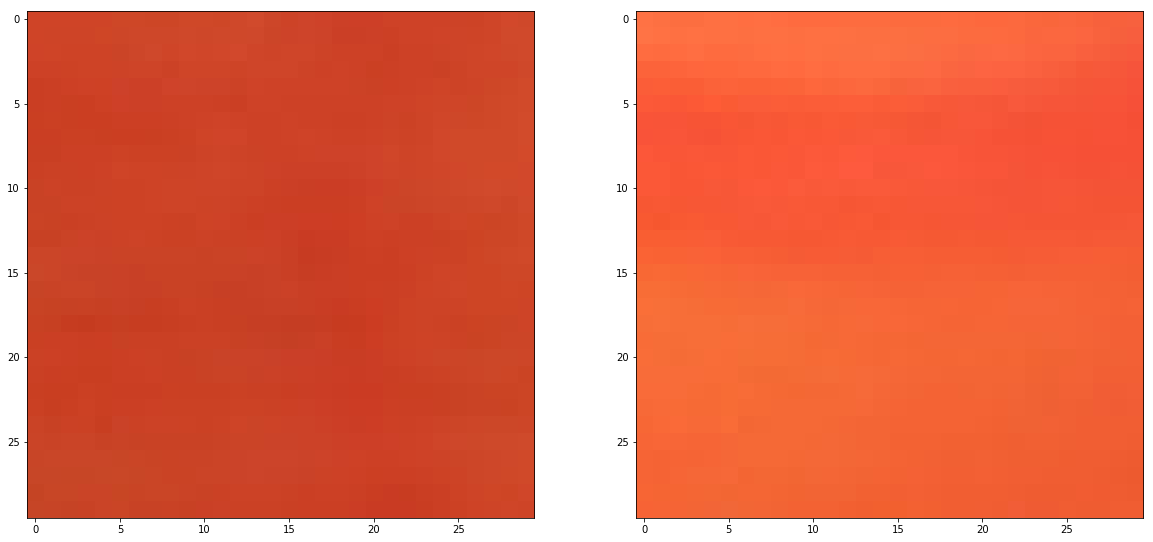

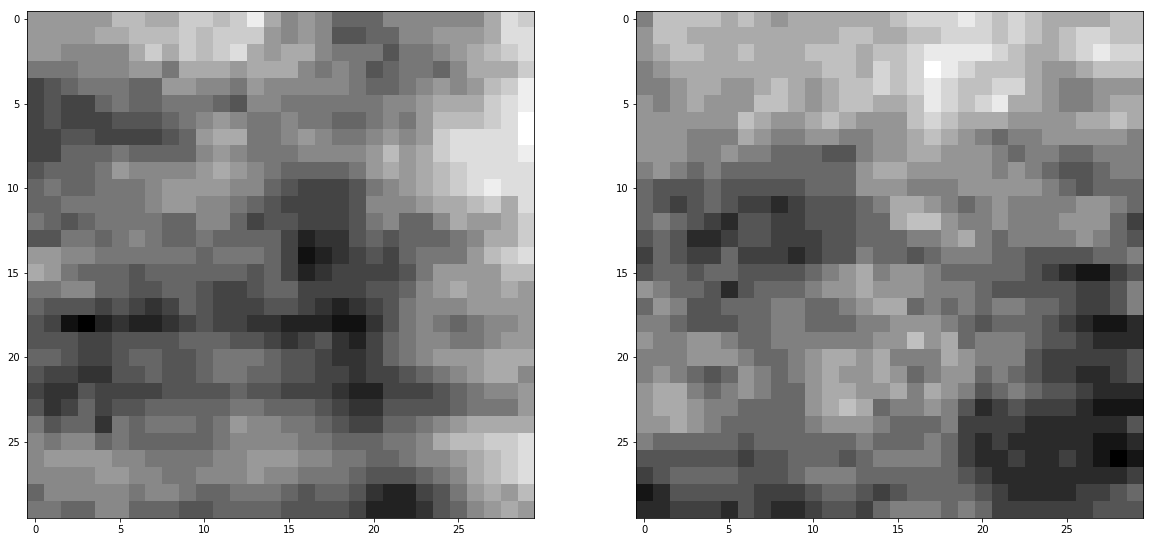

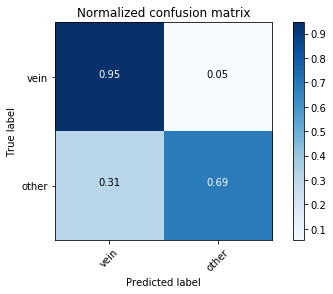

In [41]:
pictures = np.array(range(45))
imgNo = shuffle(pictures, random_state=0)
fname = '30_adadelta__binarycrossentropy.hdf5'

partSize = 30
x = prepareTrainData(imgNo[:30], partSize)
buildCNN(x, partSize, 20, fname)

In [ ]:
def cnn(no, epoch=20):

    #wczytanie sciezek i nazw plikow
    pathImages = 'HRF/images/'
    pathData = 'HRF/manual1/'
    pathMask = 'HRF/mask/'
    imagesFileList = readNames(pathImages)
    dataFileList = readNames(pathData)
    maskFileList = readNames(pathMask)

    imagesFileList.sort()
    dataFileList.sort()
    maskFileList.sort()

    #wczytanie plikow
    image = readFile(pathImages,imagesFileList[no])
    data = readFile(pathData,dataFileList[no], tif=True)
    mask = readFile(pathMask,maskFileList[no], tif=True)

    #print(mask.shape, image.shape, data.shape)

    #podzial obrazow na part**2 czesci
    dividedImages = divide1(image, mask, part=20)
    dividedData = divide1(data, mask, part=20)

    img_rows = dividedImages[0].shape[0]
    img_columns = dividedImages[0].shape[1]


    #print(len(dividedImages))
    #print(len(dividedData))

    showImg(dividedImages[0],dividedImages[-1])


    valuedImages = assignValue1(dividedImages, dividedData)

    veinImgLen = len(valuedImages[0])
    otherImgLen = len(valuedImages[1])
    size = veinImgLen + otherImgLen

    #print(size)

    #przypisanie etykiet 1-żyła, 0-inne
    labels = np.ones((size,), dtype=int)
    labels[0:veinImgLen] = 1
    labels[veinImgLen:] = 0

    images = valuedImages[0] + valuedImages[1]

    #konwersja do sklai szarości i ujednolicenie wymiarow
    grayImages = toGrayScaleAndResize(images, img_columns, img_rows)
    #print(len(grayImages))

    showImg(images[0], grayImages[0])


    #przygotowanie macierzy wektorów gdzie kazdy wiersz to wektor obrazu; flatten - spłaszczenie macierzy
    imgMatrix = np.array([np.array(img).flatten() for img in grayImages])
    #print(imgMatrix)

    #losowe rozmieszczenie obrazow w w zbiorze treningowym
    data, Label = shuffle(imgMatrix, labels, random_state=2)
    train_data = [data,Label]

    #print(train_data[0].shape, train_data[1].shape)

    #img=imgMatrix[12].reshape(img_rows, img_columns)

    (X, y) = (train_data[0],train_data[1])

    #zbiory treningowe i testowe

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


    X_train = X_train.reshape(X_train.shape[0], img_rows, img_columns, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_columns, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    #print('X_train shape:', X_train.shape)
    #print(X_train.shape[0], 'train samples')
    #print(X_test.shape[0], 'test samples')

    batch_size = 32
    nb_classes = 2
    nb_epoch = epoch
    nb_filters = 32
    nb_pool = 2
    nb_conv = 3

    Y_train = np_utils.to_categorical(y_train, nb_classes)
    Y_test = np_utils.to_categorical(y_test, nb_classes)

    #budowa modelu sieci neuronowej

    model = Sequential()

    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                            border_mode='valid',
                            input_shape=(img_rows, img_columns, 1)))
    convout1 = Activation('relu')
    model.add(convout1)
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    convout2 = Activation('relu')
    model.add(convout2)
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    #trenowanie modelu


    #hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
    #              verbose=1, validation_data=(X_test, Y_test))


    hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
                  verbose=1, validation_split=0.2)


    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    #print(model.predict_classes(X_test[1:3]))
    #print(Y_test[1:3])


    Y_pred = model.predict(X_test)
    #print(Y_pred)
    y_pred = np.argmax(Y_pred, axis=1)
    #print(y_pred)

    cm = confusion_matrix(np.argmax(Y_test,axis=1), y_pred)
    print(confusion_matrix(np.argmax(Y_test,axis=1), y_pred))

    # Plot normalized confusion matrix
    class_names = ['vein', 'other']

    plt.figure()
    plot_confusion_matrix(cm, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()


    #fname = "weights-Test-CNN2.hdf5"
    #model.save_weights(fname,overwrite=True)

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




In [13]:
def resize(img, size=30):     
    return np.resize(img,(size, size))


# liczba zdjec skladowych = part**2
def divide1(image, mask, part=10):
    dividedImages=[]
    
    rows = np.linspace(0, image.shape[0], part+1, dtype=int)
    columns = np.linspace(0, image.shape[1], part+1, dtype=int)
    
    for i in range(1, len(rows)):
        for j in range(1, len(columns)):
            m = mask[rows[i-1]:rows[i], columns[j-1]:columns[j]]
            row_centre = int((rows[i]-rows[i-1])/2)
            column_centre = int((columns[j]-columns[j-1])/2)
            #print(m[row_centre,column_centre], row_centre, column_centre)
            
            
            if (m[row_centre,column_centre,1] != 0):
                dividedImages.append(image[rows[i-1]:rows[i], columns[j-1]:columns[j]])
    return dividedImages

def checkVein(data):
    
    x = data.shape[0]
    y = data.shape[1]
    
    centre_x = int(x/2)
    centre_y = int(y/2)
    
    return data[centre_x, centre_y] != 0


def assignValue1(dividedImages, dividedData):
    trueImages = []
    falseImages = []
    for i in range(0,len(dividedImages)):
        if checkVein(dividedData[i]):
            trueImages.append(dividedImages[i])
        else:
            falseImages.append(dividedImages[i])
            
    return [trueImages, falseImages]


